In [10]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from sklearn.model_selection import train_test_split

%matplotlib inline

import os
import sys
import requests

dep_dir = os.path.abspath('dep/')
sys.path.append(dep_dir)

from plotting import normalize_image, plot_image_array, plot_confusion_matrix, plot_model_history

In [ ]:
# files = {
#     "sources": (os.path.join("data", "stamps_noise.npy"), "1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ"),
#     "noise": (os.path.join("data", "stamps_sources.npy"), "1cZaMCA0z_nPX6GB_meLGouwOidEROcwc"),
# }

# for name, file_id in files.values():
#     if not os.path.exists(name):
#         print(f"Downloading file {name}.")

#         os.makedirs(os.path.dirname(name), exist_ok=True)
#         url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
#         response = requests.post(url)
#         with open(name, "wb") as file:
#             file.write(response.content)
#     print(f"File {name} is downloaded")

# sources = np.load(files["sources"][0])
# noise = np.load(files["noise"][0])


File data/stamps_noise.npy is downloaded
File data/stamps_sources.npy is downloaded


In [6]:
point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

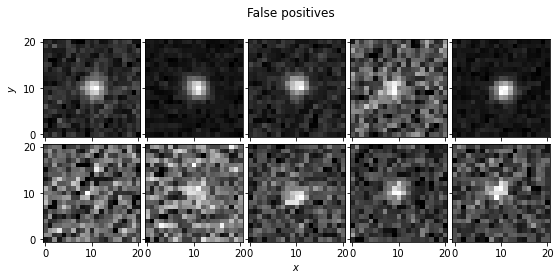

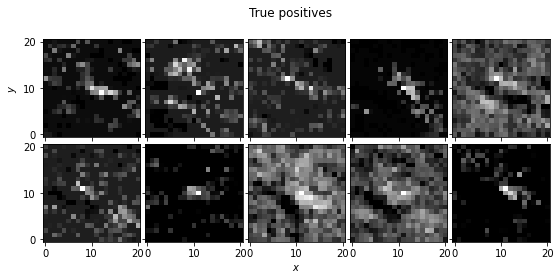

In [7]:
plot_image_array(no_point_source_stamps, title="False positives")
plot_image_array(point_source_stamps, title="True positives")

In [9]:
def reshape_arrays(data, labels):
    """reshape arrays for Keras"""
    data = data.reshape(-1, 21, 21, 1)
    labels = to_categorical(labels)
    return data, labels


# combine the false positives and true positives
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps) :] = 1  # 0 for noise, 1 for a star

# split the samples into training, validation and, test data sets:
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2
# Note: we have to use train_test_split twice
data_train_val, data_test, class_train_val, class_test = train_test_split(
    input_stamps, stamp_class, test_size=test_frac, random_state=42
)
data_train, data_val, class_train, class_val = train_test_split(
    data_train_val, class_train_val, test_size=val_frac / (train_frac + val_frac), random_state=42
)

data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print(
    f"Number of samples in the training ({data_train.shape[0]}); test ({data_test.shape[0]}); and validation ({data_val.shape[0]}) data sets"
)

print(
    f"Fraction of true samples in the training ({np.sum(class_train[:,0])/data_train.shape[0]}); test ({np.sum(class_test[:,0])/data_test.shape[0]}); and validation ({np.sum(class_val[:,0])/data_val.shape[0]}) data sets"
)


Number of samples in the training (76665); test (21905); and validation (10953) data sets
Fraction of true samples in the training (0.5466510141524816); test (0.5536635471353573); and validation (0.5444170546882132) data sets


In [11]:
def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = Sequential(name="simple")

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(Dense(30, input_shape=input_shape, activation="relu", name="fc_1"))

    model.add(Dense(30, activation="relu", name="fc_2"))

    # output layer
    model.add(Flatten(name="flatten_1"))
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Dense(n_classes, activation=activation, name="fc_out"))

    return model

In [12]:
simple_model = simple()
simple_model.summary()

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                    │ (None, 21, 21, 30)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 21, 21, 30)     │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13230)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_out (Dense)                  │ (None, 2)              │        26,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
n_epochs = 1
batch_size = 1

In [14]:
simple_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
simple_model_history = simple_model.fit(
    data_train,
    class_train,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(data_val, class_val),
    shuffle=True,
)